In [1]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)
COMMON_PATH = os.path.join(project_root, 'common')

In [2]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from financial_common.risk.rolling_factor_analysis import RollingFactorAnalysis
from financial_common.risk.single_index_capm import SingleIndexCAPM
from financial_common.indicator.indicator import Indicator
from financial_common.risk.risk_type import RiskType
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.metrics import Metrics
from financial_common.portfolio_management.portfolio_selection import PortfolioSelection
import numpy as np

In [3]:
## Import standard packages
from datetime import timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep
import copy

In [4]:
market = ADatabase("market")
fred = ADatabase("fred")

In [5]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("cryptocurrencies")
market.disconnect()

In [6]:
## Defining Benchmark
market.connect()
benchmark = market.query("crypto",{"ticker":"BTC-USD"})
benchmark = p.utc_date(benchmark)
benchmark["close"] = benchmark["close"].astype(float)
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"close")

In [7]:
market.connect()
prices = []
for ticker in tqdm(index["ticker"]): 
    try:
        price = market.query("crypto", {"ticker": ticker})
        for col in price.columns:
            if col not in ["date", "ticker"]:
                try:
                    price[col] = price[col].astype(float)
                    price.rename(columns={col:"adj"+col},inplace=True)
                except Exception as e:
                    print(str(e))
                    continue
        if price.index.size > 150:
            price = p.lower_column(price)
            price = p.utc_date(price)
        
            price.sort_values("date", inplace=True)
            price = p.additional_date_columns(price)
            for member in Indicator:
                price = member.calculate(price)
            for member in RiskType:
                price = member.apply(price)
            prices.append(price)
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

100%|███████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.12it/s]


In [8]:
model_end = 2024
backtest_end = 2026
simulation = pd.concat(prices).merge(index[["ticker","market_cap","industry"]],on="ticker",how="left")
simulation["office"] = "crypto"
simulation["sic_description"] = "crypto"
## subsetting backtesting data
simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)]
tickers = list(simulation[simulation["year"]==model_end]["ticker"].unique())
simulation = simulation[simulation["ticker"].isin(tickers)]
simulation.sort_values("date", inplace=True)
simulation.columns

Index(['adjstart', 'adjlow', 'adjhigh', 'adjopen', 'adjclose', 'adjvolume',
       'ticker', 'date', 'year', 'month', 'quarter', 'week', 'reference_price',
       'reference_volume', 'reference_high', 'reference_low',
       'rolling_dollar_volume', 'adr', 'sma', 'ema', 'bollinger_upper',
       'bollinger_lower', 'momentum', 'roc', 'williams_r', 'obv', 'vwap',
       'market_impact', 'atr', 'coefficient_of_variation', 'drawdown',
       'market_cap', 'industry', 'office', 'sic_description'],
      dtype='object')

In [9]:
portfolios = PortfolioSelection.generate_possible_portfolios(group_percentages=[0.1,0.3])

In [10]:
additional_portfolios = []

for portfolio in portfolios:
    for member in Indicator:
        portfolio_copy = copy.deepcopy(portfolio)
        portfolio_copy.ranking_metric = member.label
        additional_portfolios.append(portfolio_copy)


In [11]:
analysises = []
for portfolio in tqdm(additional_portfolios):
    try:
        trades = portfolio.trades(simulation.copy())
        performance = portfolio.portfolio(trades.copy(),benchmark.copy())
        metrics = Metrics.performance(trades,performance)
        results = {**portfolio.to_dict(),**metrics.copy()}
        results["portfolio"] = portfolio
        analysises.append(results)
    except Exception as e:
        print(str(e))
        continue

100%|█████████████████████████████████████████████████████████████████████████████████████████| 7488/7488 [22:54<00:00,  5.45it/s]


In [12]:
a = pd.DataFrame(analysises)
a.columns

Index(['timeframe', 'ranking_metric', 'position_type', 'grouping_type',
       'selection_type', 'allocation_type', 'risk_type',
       'selection_percentage', 'date', 'pnl', 'coefficient_of_variation',
       'portfolio_std', 'average_gain', 'average_loss', 'win_loss_ratio',
       'weekly_return', 'sharpe_ratio', 'portfolio'],
      dtype='object')

In [13]:
a.groupby("pnl").first().reset_index().drop("date",axis=1).sort_values("pnl",ascending=False).head(20)

,pnl,timeframe,ranking_metric,position_type,grouping_type,selection_type,allocation_type,risk_type,selection_percentage,coefficient_of_variation,portfolio_std,average_gain,average_loss,win_loss_ratio,weekly_return,sharpe_ratio,portfolio
2335,2.720604,month,bollinger_lower,short,SIC_DESCRIPTION,bottom,equal,coefficient_of_variation,0.1,4.849527,0.561004,1.120705,0.985367,0.766667,1.089126,2.606439,<financial_common.portfolio_management.portfol...
2334,2.224034,month,obv,short,SIC_DESCRIPTION,mixed,equal,coefficient_of_variation,0.1,5.046027,0.440749,1.260851,0.844892,0.550000,1.073670,2.190933,<financial_common.portfolio_management.portfol...
2333,2.092083,quarter,bollinger_upper,long,SIC_DESCRIPTION,top,equal,coefficient_of_variation,0.1,4.359575,0.479882,1.313131,0.863781,0.680000,1.169339,1.533252,<financial_common.portfolio_management.portfol...
2332,2.085750,quarter,bollinger_lower,short,SIC_DESCRIPTION,mixed,equal,coefficient_of_variation,0.1,5.164749,0.403844,1.399921,0.807348,0.640000,1.186595,1.806262,<financial_common.portfolio_management.portfol...
2331,1.897504,quarter,bollinger_lower,long,SIC_DESCRIPTION,top,equal,coefficient_of_variation,0.1,4.212630,0.450432,1.627669,0.788602,0.480000,1.191354,1.201515,<financial_common.portfolio_management.portfol...
2330,1.708621,quarter,rolling_dollar_volume,long,SIC_DESCRIPTION,top,equal,coefficient_of_variation,0.1,4.454717,0.383553,1.499565,0.788518,0.520000,1.158262,0.918565,<financial_common.portfolio_management.portfol...
2329,1.690150,quarter,vwap,short,SIC_DESCRIPTION,mixed,equal,coefficient_of_variation,0.1,6.841934,0.247028,1.348408,0.701404,0.640000,1.115486,1.351453,<financial_common.portfolio_management.portfol...
2328,1.686894,month,bollinger_lower,short,SIC_DESCRIPTION,mixed,equal,coefficient_of_variation,0.1,6.350659,0.265625,1.216663,0.856976,0.550000,1.054804,1.613224,<financial_common.portfolio_management.portfol...
2327,1.636998,month,atr,short,SIC_DESCRIPTION,mixed,equal,coefficient_of_variation,0.1,7.571428,0.216207,1.215230,0.842465,0.550000,1.047486,1.751174,<financial_common.portfolio_management.portfol...
2326,1.601040,quarter,momentum,long,SIC_DESCRIPTION,mixed,equal,coefficient_of_variation,0.1,5.815408,0.275310,1.409566,0.781194,0.520000,1.107947,0.888951,<financial_common.portfolio_management.portfol...


In [14]:
a["color"] = ["blue" if x == "top" else "red" if x == "bottom"  else "green" for x in a["selection_type"]]
a["return_to_risk"] = a["pnl"] / a["portfolio_std"]

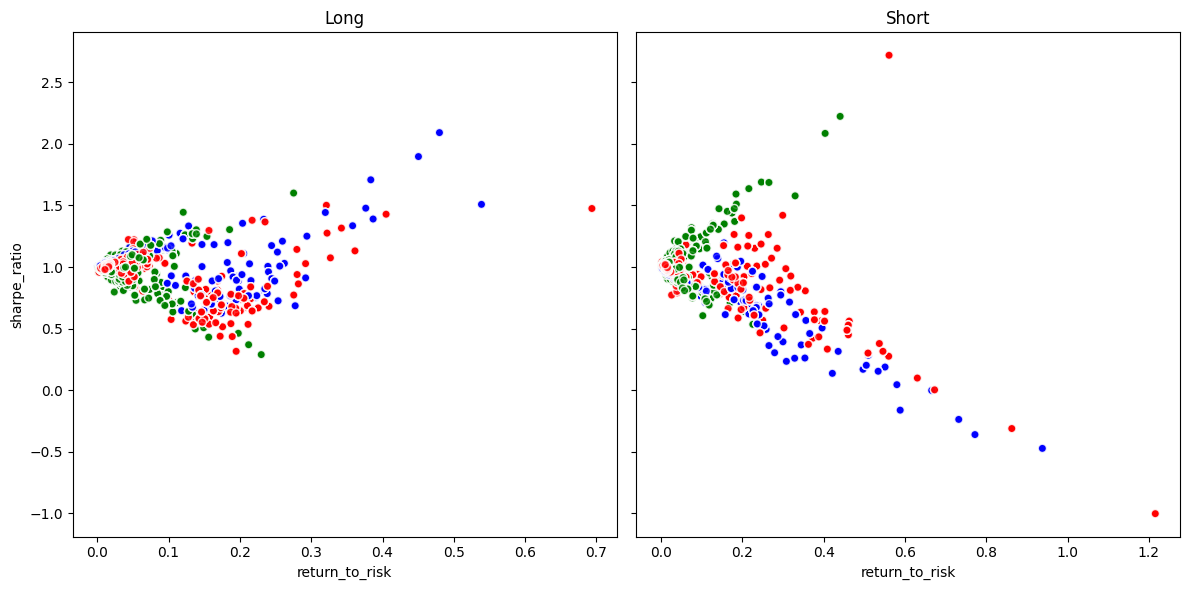

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Titles for each subplot
titles = ["Long", "Short"]

# Iterate over directions and corresponding axes
for i, position_type in enumerate(["long", "short"]):
    d_analysis = a[a["position_type"] == position_type]
    axes[i].scatter(
        d_analysis["portfolio_std"],
        d_analysis["pnl"],
        c=d_analysis["color"],
        alpha=0.8,
        edgecolors="w",
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("return_to_risk")
    axes[i].set_ylabel("sharpe_ratio" if i == 0 else "")  # Only label y-axis on the first plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [16]:
top = a.sort_values("pnl",ascending=False).head(1).to_dict("records")[0]
top

{'timeframe': 'month',
 'ranking_metric': 'bollinger_lower',
 'position_type': 'short',
 'grouping_type': 'SIC_DESCRIPTION',
 'selection_type': 'bottom',
 'allocation_type': 'equal',
 'risk_type': 'drawdown',
 'selection_percentage': 0.1,
 'date': Timestamp('2025-04-18 00:00:00+0000', tz='UTC'),
 'pnl': 2.7206042826065464,
 'coefficient_of_variation': 4.849526641811893,
 'portfolio_std': 0.561004090409547,
 'average_gain': 1.1207053133478104,
 'average_loss': 0.9853672824052561,
 'win_loss_ratio': 0.7666666666666667,
 'weekly_return': 1.0891264394612143,
 'sharpe_ratio': 2.6064390274612093,
 'portfolio': <financial_common.portfolio_management.portfolio.Portfolio at 0x1c7064d9990>,
 'color': 'red',
 'return_to_risk': 4.849526641811893}

In [17]:
pm = top["portfolio"]
trades = pm.trades(simulation.copy()).merge(index[["ticker","industry"]],on="ticker",how="left")
trades = p.additional_date_columns(trades)
portfolio = pm.portfolio(trades.copy(),benchmark.copy())
portfolio = p.additional_date_columns(portfolio)

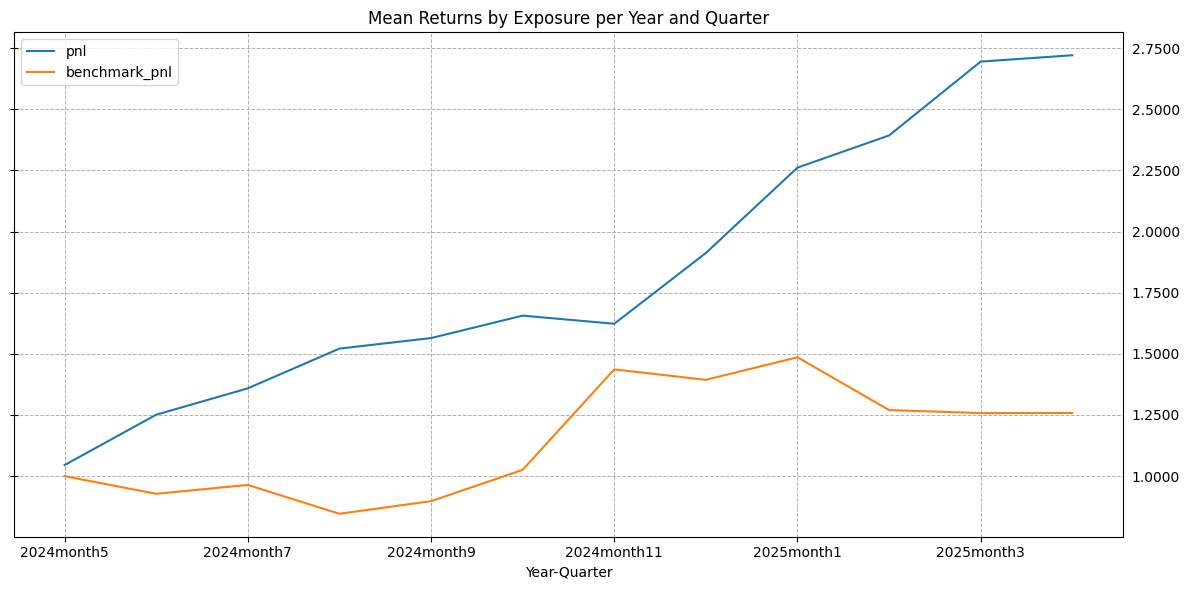

In [18]:
portfolio['Year-Quarter'] = portfolio["year"].astype(str) + pm.timeframe + portfolio[pm.timeframe].astype(str)
ax = portfolio[["Year-Quarter","pnl","benchmark_pnl"]].set_index("Year-Quarter").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Set y-axis to have more precise ticks
ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# Move y-ticks to the right side
ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# Optionally adjust the number of ticks for better precision
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# Add grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [19]:
trades[["ticker","return"]].groupby("ticker").mean().sort_values("return",ascending=False)

,return
ticker,
FET-USD,1.298858
SOL-USD,1.291126
STX-USD,1.264649
HNT-USD,1.246676
MKR-USD,1.233112
DOT-USD,1.160366
ETC-USD,1.135875
ETH-USD,1.132228
HBAR-USD,1.094936


In [20]:
(a["portfolio_std"]/a["portfolio_std"].sum() * a["pnl"]).sum()

0.8314912031587403